In [1]:
from scipy import stats
import arviz as az
import pymc as pm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Example 1 working though the application of Beyesian Statistics.

general hypothesis is that Bayesian methods may prove useful when screening for KPI improvements in phenotype of engineering strains of synthetic organisms. 
Noisy measurements, limited replicates, biological/technical variation can make finding "hits" a challenge.
Will this statistical method reduce the cost to find a "hit"?

[Hands-on Bayesian Statistics with Python (PyMC3 & ArviZ)](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)

...I get the rough idea of what "Bayes Theorem" says, but I have no idea how to apply it to the data in front of me or what tools to use.


25798
insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64


([<matplotlib.axis.YTick at 0x1ad75109040>], [Text(0, 0, '0')])

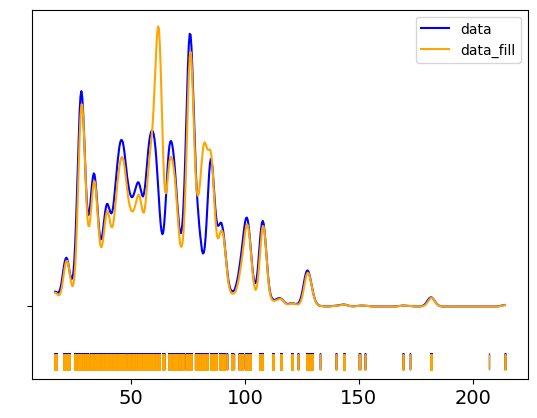

In [2]:
data = pd.read_csv('data/example1_data.csv')
data.loc[data['train_class'].isnull()]

print(len(data))
print(data.isnull().sum() / len(data))


plt.yticks([0], alpha=0)

data_fill = data.sample(n=len(data))

data_fill['train_class'] = data_fill['train_class'].fillna(data_fill['train_class'].mode().iloc[0])
data_fill['fare'] = data_fill['fare'].fillna(data_fill['fare'].mode().iloc[0])
data_fill['price'] = data_fill.groupby('fare')['price'].transform(lambda x: x.fillna(x.mean()))

az.plot_kde(data['price'].values, rug=True, label='data', plot_kwargs={'color': 'blue'})
az.plot_kde(data_fill['price'].values, rug=True, label='data_fill', plot_kwargs={'color': 'orange'})
plt.yticks([0], alpha=0)



([<matplotlib.axis.YTick at 0x1ad75440070>], [Text(0, 0, '0')])

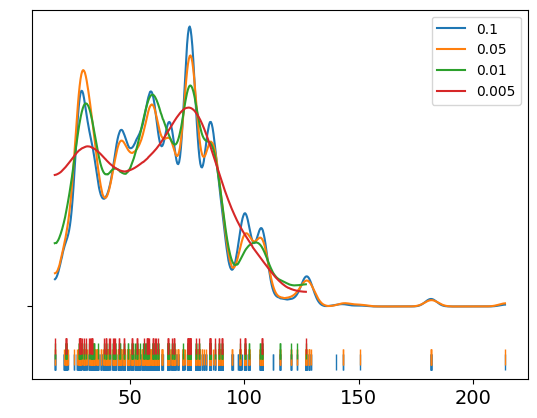

In [3]:
sample_frac = [0.1, 0.05, 0.01, 0.005]
c_palette = sns.color_palette()

for idx, frac in enumerate(sample_frac):
    data_sample = data.sample(frac=frac, random_state=99)
    az.plot_kde(data_sample['price'].values, label=str(frac), rug=True, plot_kwargs={'color': c_palette[idx]})

plt.yticks([0], alpha=0)

In [4]:
data_working = data_fill.sample(frac=0.01, random_state=99)

- Ran this without filling data and get "ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution."
- Ran this without sampling data and NUTS sampling was going to take a very long time with 25k values, sampled at frac=0.01

In [5]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=0, upper=300)
    sigma = pm.HalfNormal('sigma', sigma=0)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_working['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


In [30]:
trace_g.posterior.data_vars['mu']

<xarray.DataArray 'mu' (chain: 4, draw: 1000)>
array([[68.3394982 , 69.94371569, 65.91170951, ..., 70.54412437,
        66.5627591 , 66.80484071],
       [66.32624358, 70.33028098, 70.33028098, ..., 66.48676781,
        68.91951309, 68.18321974],
       [67.6707481 , 69.60350426, 67.79569396, ..., 68.83666301,
        68.15009999, 68.15009999],
       [66.5764142 , 66.4682359 , 67.2102896 , ..., 66.92978645,
        67.82175371, 67.82175371]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [39]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,68.469,1.629,65.524,71.573,0.024,0.017,4555.0,3145.0,1.0
sigma,25.363,1.083,23.442,27.529,0.016,0.012,4460.0,2892.0,1.0


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

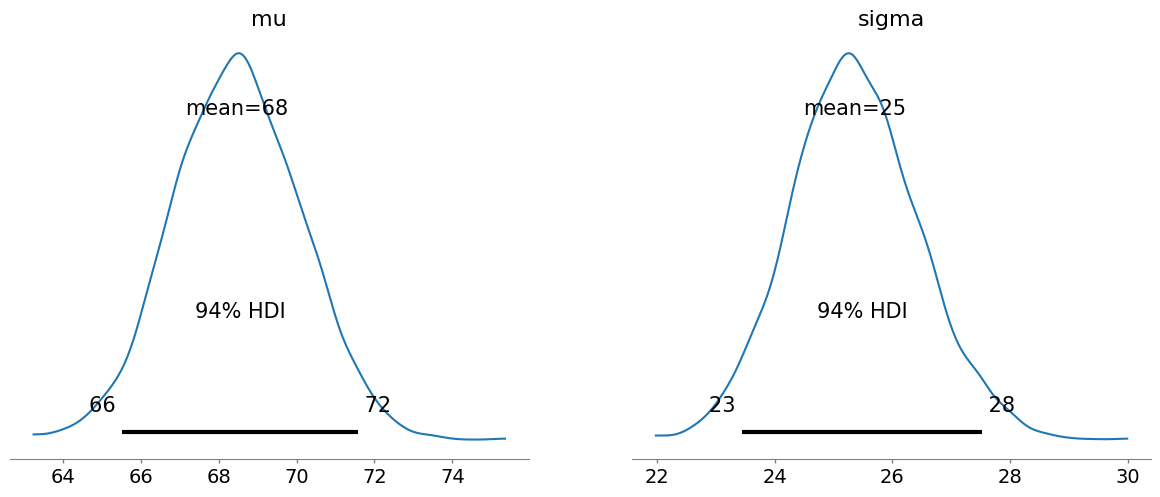

In [43]:
az.plot_posterior(trace_g, kind='kde')

<Axes: xlabel='mu', ylabel='sigma'>

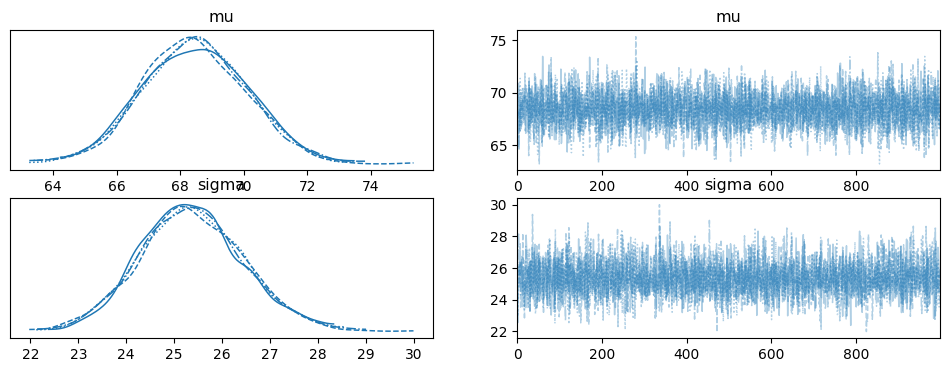

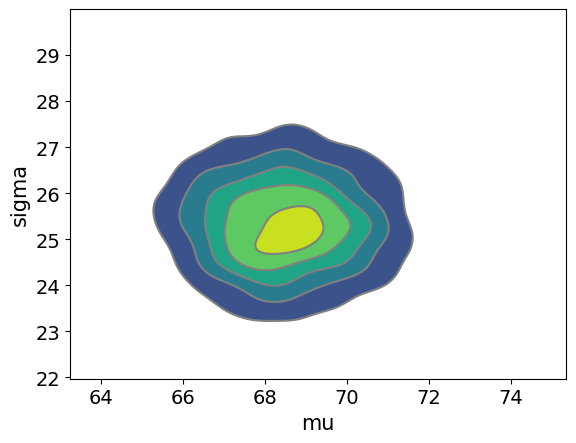

In [40]:
az.plot_trace(trace_g)
az.plot_pair(trace_g, kind='kde')